<a href="https://colab.research.google.com/github/korymath/public_notebooks/blob/master/Building_Equal_Size_Clusters_Kyle_Mathewson_Sept_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

np.random.seed(random_state)

# Generate and Visualize Data

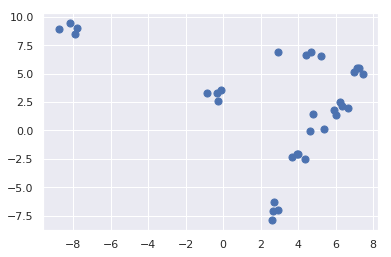

In [173]:
n_samples = 32
n_groups = 8
n_members = 4

random_state = 1017

# ensure that the calculus works out
assert n_groups * n_members == n_samples

X, y_true = make_blobs(n_samples=n_samples, centers=n_groups,
                       cluster_std=0.50, random_state=random_state)
plt.scatter(X[:, 0], X[:, 1], s=50);

# K-Means Clustering

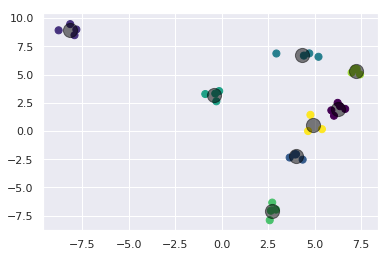

In [174]:
kmeans = KMeans(n_clusters=n_groups, n_init=100, max_iter=1000)
kmeans.fit(X)
labels = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [175]:
# test the group size, AssertionError on failure
C = Counter(labels)
print('Group sizes: {}'.format(C))

try:
  assert list(C.values()) == [n_members] * n_groups
except AssertionError as e:
  print('Unequal group sizes')

Group sizes: Counter({0: 5, 2: 4, 1: 4, 4: 4, 3: 4, 5: 4, 6: 4, 7: 3})
Unequal group sizes


# (optional) Explicit Algorithm Details

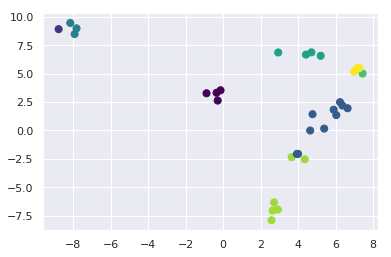

In [176]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=random_state):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X=X, n_clusters=n_groups)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

# Limitations of K-Means

1. Global optimum not guaranteed
2. n_groups must be selected beforehand
3. limited to linear cluster boundaries
4. slow for large n_samples
5. group sizes unequal

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


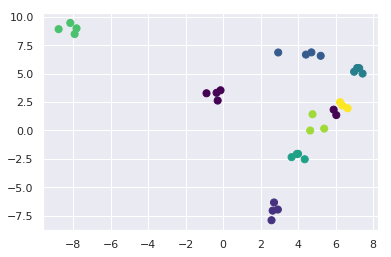

In [177]:
# To address limitation 1, we can increase n_init for different random
# starting points on centroids. We can also increase the number of iterations
# particularly if there is a small n_samples

# To address limitation 3, we can use spectral clustering

# use a kernel transformation to project the data into a higher dimension where 
# a linear separation is possible. 
# Allow k-means to discover non-linear boundaries.

from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=n_groups, affinity='nearest_neighbors',
                           assign_labels='kmeans', n_neighbors=n_members,
                           n_init=100, random_state=random_state)
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

In [178]:
# test the group size, AssertionError on failure
C = Counter(labels)
print('Group sizes: {}'.format(C))

try:
  assert list(C.values()) == [n_members] * n_groups
except AssertionError as e:
  print('Unequal group sizes')

Group sizes: Counter({0: 6, 4: 4, 5: 4, 2: 4, 1: 4, 3: 4, 7: 3, 6: 3})
Unequal group sizes


# Contrained Group Size k-means Clustering

In [0]:
def cluster_equal_groups(X, K=None, G=None, verbose=False):
    # equal-size clustering based on data exchanges between pairs of clusters
    # K is the group size
    # G is the number of clusters

    def error(K, m, D):
        # return average distances between data in one cluster
        # averaged over all clusters
        
        E = 0
        for k in range(K):
            # indeces of datapoints belonging to class k
            i = np.where(m == k)[0] 
            E += np.mean(D[tuple(np.meshgrid(i,i))])
        return E / K
    
    # given two of three num_points, num_clusters, group_size the third
    # is trivial to calculate
    N, n = X.shape
    if G is None and K is not None:
        G = N // K # group size
    elif K is None and G is not None:
        K = N // G # number of clusters
    else:
        raise Exception('must specify either K or G')
        
    # distance matrix
    D = squareform(pdist(X)) 
    
    # initial membership
    # TODO(korymath): it is likely more efficient to start from the output
    # of the k-means clustering algorithm, but not necessary for this
    # small example
    m = np.random.permutation(N) % K 
    E = error(K, m, D)

    t = 1
    while True:
        E_p = E
        for a in range(N):
            for b in range(a):
                # exchange membership
                m[a], m[b] = m[b], m[a] 
                E_t = error(K, m, D)
                if E_t < E:
                    E = E_t
                    if verbose:
                      print("{}: {}<->{} E={}".format(t, a, b, E))
                else:
                    # put them back
                    m[a], m[b] = m[b], m[a] 
        if E_p == E:
            break
        t += 1    
    return m

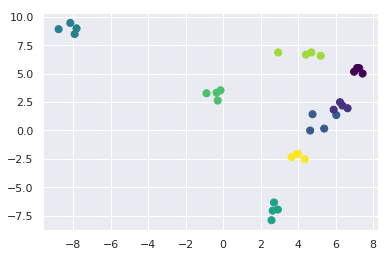

In [180]:
labels = cluster_equal_groups(X, G=4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

In [181]:
# test the group size, AssertionError on failure
C = Counter(labels)
print('Group sizes: {}'.format(C))

try:
  assert list(C.values()) == [n_members] * n_groups
except AssertionError as e:
  print('Unequal group sizes')

Group sizes: Counter({7: 4, 3: 4, 5: 4, 6: 4, 1: 4, 2: 4, 4: 4, 0: 4})
